# Module 6: Generalization Performance 

* Consider our original regression dataset in the Figure below

* We can fit simple polynomial functions with various degrees to this dataset. We'll pick degree = 1 (blue), 5 (purple), and 15 (magenta).

$$\hat{y}(x)=\beta_{0}+\beta_{1}x+...+\beta_{n}x^{n}$$

* The higher the degree of the polynomial, the more parameters, and hence, the more complex the model

![alt text](figures/generalization_training.png)


* Clearly, as the degree increases, the MSE on the dataset decreases.

* But, look at what happens when we measure MSE on data points the model has not been trained on:

![alt text](figures/generalization_testing.png)

* The most complex model has the worst MSE on unseen data, despite having the best MSE on the training data

* We say that the model has _overfitted_ to the training dataset: it mistook noise for an actual signal.

* This is why we _must_ evaluate our models on data the model has not been trained on

## Tracking Training and Testing Performance

* Before we do that, lets see how our neural network models can overfit. We'll take our binary classification example, train on the first 100 points and evaluate the remaining points.




In [51]:
import numpy as np
import numpy.random as rng 
import tensorflow as tf
import matplotlib.pyplot as plt 
import sklearn.metrics

# try varying the number of hidden units
n_hidden = 30
eta = 0.1

# read data
data = np.load('data/binary_classification.npz')
X, y = data['X'], data['y']

ix = rng.permutation(X.shape[0])
X = X[ix, :]
y = y[ix, :]

n_points = 100
Xtrain = X[:n_points,:]
ytrain = y[:n_points,:]
Xtest = X[n_points:,:]
ytest = y[n_points:,:]

# move data to tensorflow space
Xtrain = tf.convert_to_tensor(Xtrain, dtype=tf.float32)
ytrain = tf.convert_to_tensor(ytrain, dtype=tf.float32)
Xtest = tf.convert_to_tensor(Xtest, dtype=tf.float32)
ytest = tf.convert_to_tensor(ytest, dtype=tf.float32)

# randomly initialize model parameters
W_input_hidden = tf.Variable(rng.randn(X.shape[1], n_hidden), dtype=tf.float32) 
W_hidden_output = tf.Variable(rng.randn(n_hidden, 1), dtype=tf.float32)
b_hidden = tf.Variable(rng.randn(n_hidden), dtype=tf.float32)
b_output = tf.Variable(rng.randn(1), dtype=tf.float32)
variables = [W_input_hidden, W_hidden_output, b_hidden, b_output]

# create optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=eta)

# repeat N times
N = 5000
train_xe = []
test_xe = []
for i in range(N):
    
    with tf.GradientTape() as gt:
        
        # forward computation
        hidden_activation = tf.tanh(b_hidden + tf.matmul(Xtrain, W_input_hidden))
        pi = tf.sigmoid(b_output + tf.matmul(hidden_activation, W_hidden_output))
        xe_loss = -tf.reduce_mean( ytrain * tf.math.log(pi) + (1-ytrain) * tf.math.log(1-pi) )
        
    train_xe.append(xe_loss.numpy())
    
        #print("LOSS: %0.4f" % (xe_loss.numpy()))
    # compute gradient of loss with respect to parameters
    # calculus NOT required!
    gradients = gt.gradient(xe_loss, variables)
    
    # update the parameters
    # this takes a list where each element is a tuple
    # of (gradient, corresponding parameter)
    optimizer.apply_gradients(zip(gradients, variables))

    # forward computation
    hidden_activation = tf.tanh(b_hidden + tf.matmul(Xtest, W_input_hidden))
    pi = tf.sigmoid(b_output + tf.matmul(hidden_activation, W_hidden_output))
    test_xe_loss = -tf.reduce_mean( ytest * tf.math.log(pi) + (1-ytest) * tf.math.log(1-pi) )
    test_xe.append(test_xe_loss.numpy())


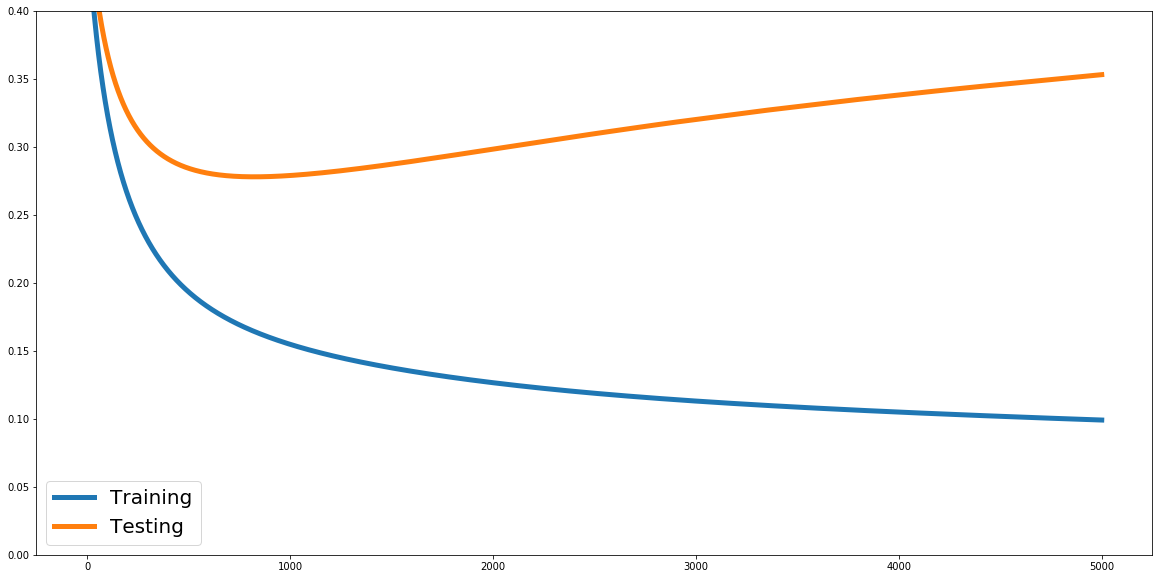

In [52]:
f, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(np.arange(N), train_xe, label='Training', linewidth=5)
ax.plot(np.arange(N), test_xe, label='Testing', linewidth=5)
ax.set_ylim([0, 0.4])
ax.legend(fontsize=20)

* Initially, the testing and training performance both improve

* After about 500 iterations, testing performance starts getting worse while training continues improving; this is the point of overfitting

## Fighting Overfitting: Dropout

* With dropout, neurons are randomly "turned-off" with some probability $p$.
* The theory behind dropout is that it encourages neurons to specialize and not rely on other neurons
* Let's add dropout to our earlier example

In [58]:
import numpy as np
import numpy.random as rng 
import tensorflow as tf
import matplotlib.pyplot as plt 
import sklearn.metrics


n_hidden = 30
eta = 0.1
dropout_p = 0.5 # try varying dropout rates

# read data
data = np.load('data/binary_classification.npz')
X, y = data['X'], data['y']

ix = rng.permutation(X.shape[0])
X = X[ix, :]
y = y[ix, :]

n_points = 100
Xtrain = X[:n_points,:]
ytrain = y[:n_points,:]
Xtest = X[n_points:,:]
ytest = y[n_points:,:]

# move data to tensorflow space
Xtrain = tf.convert_to_tensor(Xtrain, dtype=tf.float32)
ytrain = tf.convert_to_tensor(ytrain, dtype=tf.float32)
Xtest = tf.convert_to_tensor(Xtest, dtype=tf.float32)
ytest = tf.convert_to_tensor(ytest, dtype=tf.float32)

# randomly initialize model parameters
W_input_hidden = tf.Variable(rng.randn(X.shape[1], n_hidden), dtype=tf.float32) 
W_hidden_output = tf.Variable(rng.randn(n_hidden, 1), dtype=tf.float32)
b_hidden = tf.Variable(rng.randn(n_hidden), dtype=tf.float32)
b_output = tf.Variable(rng.randn(1), dtype=tf.float32)
variables = [W_input_hidden, W_hidden_output, b_hidden, b_output]

# create optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=eta)

# repeat N times
N = 5000
train_xe = []
test_xe = []
for i in range(N):
    
    with tf.GradientTape() as gt:
        
        # forward computation -- notice the dropout
        hidden_activation = tf.tanh(b_hidden + tf.matmul(Xtrain, W_input_hidden))
        
        # dropout layer
        hidden_activation = tf.nn.dropout(hidden_activation, rate=dropout_p)
        
        pi = tf.sigmoid(b_output + tf.matmul(hidden_activation, W_hidden_output))
        xe_loss = -tf.reduce_mean( ytrain * tf.math.log(pi) + (1-ytrain) * tf.math.log(1-pi) )
        
    
    #print("LOSS: %0.4f" % (xe_loss.numpy()))
    # compute gradient of loss with respect to parameters
    # calculus NOT required!
    gradients = gt.gradient(xe_loss, variables)
    
    # update the parameters
    # this takes a list where each element is a tuple
    # of (gradient, corresponding parameter)
    optimizer.apply_gradients(zip(gradients, variables))

    
    # forward computation to compute train loss without dropout
    # notice that we don't use dropout here
    hidden_activation = tf.tanh(b_hidden + tf.matmul(Xtrain, W_input_hidden))
    pi = tf.sigmoid(b_output + tf.matmul(hidden_activation, W_hidden_output))
    train_xe_loss = -tf.reduce_mean( ytrain * tf.math.log(pi) + (1-ytrain) * tf.math.log(1-pi) )
    train_xe.append(train_xe_loss.numpy())
    
    # forward computation to compute test loss
    # notice that we don't use dropout here
    hidden_activation = tf.tanh(b_hidden + tf.matmul(Xtest, W_input_hidden))
    pi = tf.sigmoid(b_output + tf.matmul(hidden_activation, W_hidden_output))
    test_xe_loss = -tf.reduce_mean( ytest * tf.math.log(pi) + (1-ytest) * tf.math.log(1-pi) )
    test_xe.append(test_xe_loss.numpy())
  

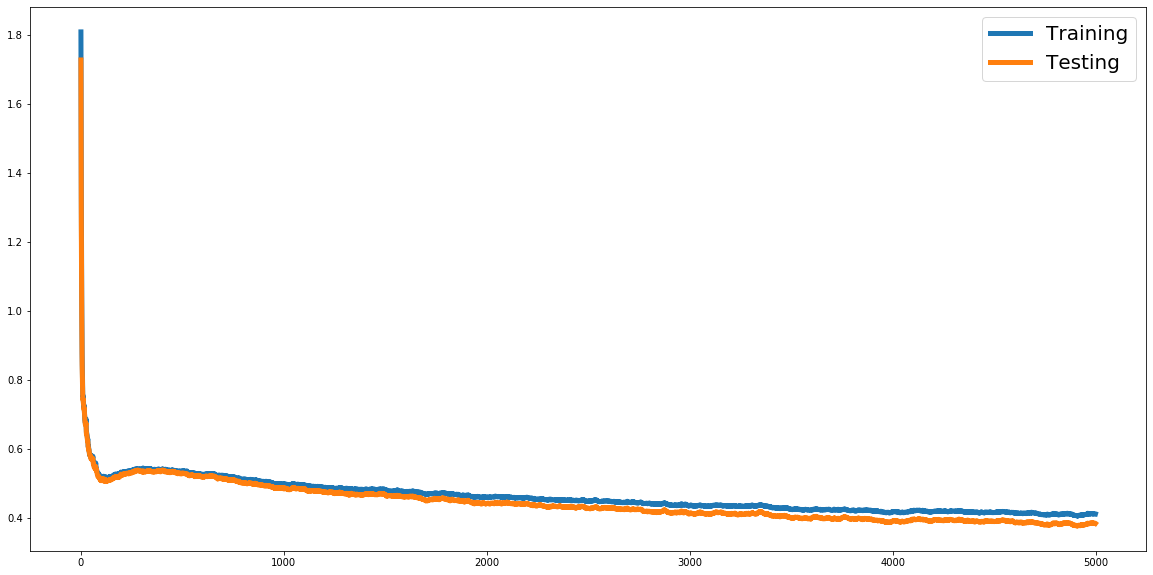

In [59]:
  
f, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(np.arange(N), train_xe, label='Training', linewidth=5)
ax.plot(np.arange(N), test_xe, label='Testing', linewidth=5)
ax.legend(fontsize=20)

## Fighting Overfitting: Regularization

* An extra term is a added to the loss function to penalize network weights that are too large. For example, the common L2 regularization scheme adds a summation of all network weights squared:

$$\mathcal{L}(\hat{y}_{i},y_{i})=\mathcal{L}_{MSE}(\hat{y}_{i},y_{i})+0.5\lambda\sum_{j}w_{j}^{2}$$

* L2 regularization encourages diffuse weight vectors and discourages vectors with large individual weights

* The regularization parameter $\lambda$ has to be determined ahead of time

In [73]:
import numpy as np
import numpy.random as rng 
import tensorflow as tf
import matplotlib.pyplot as plt 
import sklearn.metrics


n_hidden = 30
eta = 0.1
lam = 0.01

# read data
data = np.load('data/binary_classification.npz')
X, y = data['X'], data['y']

ix = rng.permutation(X.shape[0])
X = X[ix, :]
y = y[ix, :]

n_points = 100
Xtrain = X[:n_points,:]
ytrain = y[:n_points,:]
Xtest = X[n_points:,:]
ytest = y[n_points:,:]

# move data to tensorflow space
Xtrain = tf.convert_to_tensor(Xtrain, dtype=tf.float32)
ytrain = tf.convert_to_tensor(ytrain, dtype=tf.float32)
Xtest = tf.convert_to_tensor(Xtest, dtype=tf.float32)
ytest = tf.convert_to_tensor(ytest, dtype=tf.float32)

# randomly initialize model parameters
W_input_hidden = tf.Variable(rng.randn(X.shape[1], n_hidden), dtype=tf.float32) 
W_hidden_output = tf.Variable(rng.randn(n_hidden, 1), dtype=tf.float32)
b_hidden = tf.Variable(rng.randn(n_hidden), dtype=tf.float32)
b_output = tf.Variable(rng.randn(1), dtype=tf.float32)
variables = [W_input_hidden, W_hidden_output, b_hidden, b_output]

# create optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=eta)

# repeat N times
N = 5000
train_xe = []
test_xe = []
for i in range(N):
    
    with tf.GradientTape() as gt:
        
        # forward computation
        hidden_activation = tf.tanh(b_hidden + tf.matmul(Xtrain, W_input_hidden))
        pi = tf.sigmoid(b_output + tf.matmul(hidden_activation, W_hidden_output))
        xe_loss = -tf.reduce_mean( ytrain * tf.math.log(pi) + (1-ytrain) * tf.math.log(1-pi) )
        regularizer = lam * (tf.nn.l2_loss(W_input_hidden) + tf.nn.l2_loss(W_hidden_output))
        xe_loss = xe_loss + regularizer
    
    #print("LOSS: %0.4f" % (xe_loss.numpy()))
    # compute gradient of loss with respect to parameters
    # calculus NOT required!
    gradients = gt.gradient(xe_loss, variables)
    
    # update the parameters
    # this takes a list where each element is a tuple
    # of (gradient, corresponding parameter)
    optimizer.apply_gradients(zip(gradients, variables))

    
    # forward computation to compute train loss without dropout
    # notice that we don't use dropout here
    hidden_activation = tf.tanh(b_hidden + tf.matmul(Xtrain, W_input_hidden))
    pi = tf.sigmoid(b_output + tf.matmul(hidden_activation, W_hidden_output))
    train_xe_loss = -tf.reduce_mean( ytrain * tf.math.log(pi) + (1-ytrain) * tf.math.log(1-pi) )
    train_xe.append(train_xe_loss.numpy())
    
    # forward computation to compute test loss
    # notice that we don't use dropout here
    hidden_activation = tf.tanh(b_hidden + tf.matmul(Xtest, W_input_hidden))
    pi = tf.sigmoid(b_output + tf.matmul(hidden_activation, W_hidden_output))
    test_xe_loss = -tf.reduce_mean( ytest * tf.math.log(pi) + (1-ytest) * tf.math.log(1-pi) )
    test_xe.append(test_xe_loss.numpy())
  

Accuracy: 0.89


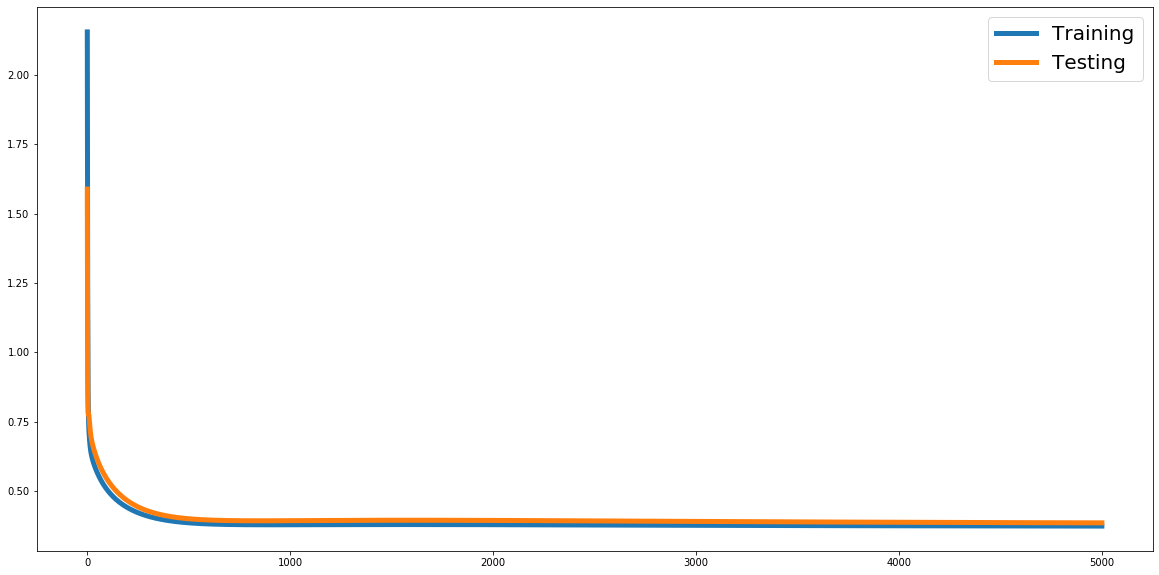

In [74]:
  
f, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(np.arange(N), train_xe, label='Training', linewidth=5)
ax.plot(np.arange(N), test_xe, label='Testing', linewidth=5)
ax.legend(fontsize=20)

# report results
hidden_activation = tf.tanh(b_hidden + tf.matmul(Xtest, W_input_hidden))
pi = tf.sigmoid(b_output + tf.matmul(hidden_activation, W_hidden_output))
pi = pi.numpy()
pred_1 = pi > 0.5
acc = np.mean(ytest.numpy()[:,0] == pred_1[:,0])
print("Accuracy: %0.2f" % acc)


## Fighting Overfitting: Early-Stopping

* Early-stopping requires that the _training_ data be split into two parts: _training_ and _validation_.

* Gradient descent is performed on training data

* The loss on the training and validation sets is monitored per epoch

* When the loss on the validation set starts increasing, training stops and the parameters from the epoch with the best validation loss are used for the final model

In [86]:
import numpy as np
import numpy.random as rng 
import tensorflow as tf
import matplotlib.pyplot as plt 
import sklearn.metrics

n_hidden = 30
eta = 0.1
patience = 100

# read data
data = np.load('data/binary_classification.npz')
X, y = data['X'], data['y']

ix = rng.permutation(X.shape[0])
X = X[ix, :]
y = y[ix, :]

n_train_points = 60
n_valid_points = 40
Xtrain = X[:n_train_points,:]
ytrain = y[:n_train_points,:]
Xvalid = X[n_train_points:(n_train_points + n_valid_points),:]
yvalid = y[n_train_points:(n_train_points + n_valid_points),:]
Xtest = X[(n_train_points + n_valid_points):,:]
ytest = y[(n_train_points + n_valid_points):,:]

# move data to tensorflow space
Xtrain = tf.convert_to_tensor(Xtrain, dtype=tf.float32)
ytrain = tf.convert_to_tensor(ytrain, dtype=tf.float32)
Xvalid = tf.convert_to_tensor(Xvalid, dtype=tf.float32)
yvalid = tf.convert_to_tensor(yvalid, dtype=tf.float32)
Xtest = tf.convert_to_tensor(Xtest, dtype=tf.float32)
ytest = tf.convert_to_tensor(ytest, dtype=tf.float32)

# randomly initialize model parameters
W_input_hidden = tf.Variable(rng.randn(X.shape[1], n_hidden), dtype=tf.float32) 
W_hidden_output = tf.Variable(rng.randn(n_hidden, 1), dtype=tf.float32)
b_hidden = tf.Variable(rng.randn(n_hidden), dtype=tf.float32)
b_output = tf.Variable(rng.randn(1), dtype=tf.float32)
variables = [W_input_hidden, W_hidden_output, b_hidden, b_output]

# create optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=eta)

# repeat N times
N = 5000
train_xe = []
valid_xe = []
test_xe = []

best_model = None
for i in range(N):
    
    with tf.GradientTape() as gt:
        
        # forward computation
        hidden_activation = tf.tanh(b_hidden + tf.matmul(Xtrain, W_input_hidden))
        pi = tf.sigmoid(b_output + tf.matmul(hidden_activation, W_hidden_output))
        xe_loss = -tf.reduce_mean( ytrain * tf.math.log(pi) + (1-ytrain) * tf.math.log(1-pi) )
    
    gradients = gt.gradient(xe_loss, variables)
    
    optimizer.apply_gradients(zip(gradients, variables))

    
    hidden_activation = tf.tanh(b_hidden + tf.matmul(Xtrain, W_input_hidden))
    pi = tf.sigmoid(b_output + tf.matmul(hidden_activation, W_hidden_output))
    train_xe_loss = -tf.reduce_mean( ytrain * tf.math.log(pi) + (1-ytrain) * tf.math.log(1-pi) )
    train_xe.append(train_xe_loss.numpy())
    
    hidden_activation = tf.tanh(b_hidden + tf.matmul(Xvalid, W_input_hidden))
    pi = tf.sigmoid(b_output + tf.matmul(hidden_activation, W_hidden_output))
    valid_xe_loss = -tf.reduce_mean( yvalid * tf.math.log(pi) + (1-yvalid) * tf.math.log(1-pi) )
    valid_xe.append(valid_xe_loss.numpy())
    
    hidden_activation = tf.tanh(b_hidden + tf.matmul(Xtest, W_input_hidden))
    pi = tf.sigmoid(b_output + tf.matmul(hidden_activation, W_hidden_output))
    test_xe_loss = -tf.reduce_mean( ytest * tf.math.log(pi) + (1-ytest) * tf.math.log(1-pi) )
    test_xe.append(test_xe_loss.numpy())
    
    min_valid_loss_ix = np.argmin(valid_xe)
    
    #
    # early stopping logic
    #
    
    # if we have a new minimum, store parameter values
    if min_valid_loss_ix == len(valid_xe) - 1:
        # store values
        best_model = []
        for v in variables:
            best_model.append(v.numpy())
    else:
        
        epochs_waiting = i - min_valid_loss_ix
        if epochs_waiting >= patience:
            
            # load the best values into the model
            for i, v in enumerate(variables):
                v.assign(best_model[i])
            
            # terminate
            break

# report results
hidden_activation = tf.tanh(b_hidden + tf.matmul(Xtest, W_input_hidden))
pi = tf.sigmoid(b_output + tf.matmul(hidden_activation, W_hidden_output))
pi = pi.numpy()
pred_1 = pi > 0.5
acc = np.mean(ytest.numpy()[:,0] == pred_1[:,0])
print("Accuracy: %0.2f" % acc)

Accuracy: 0.88


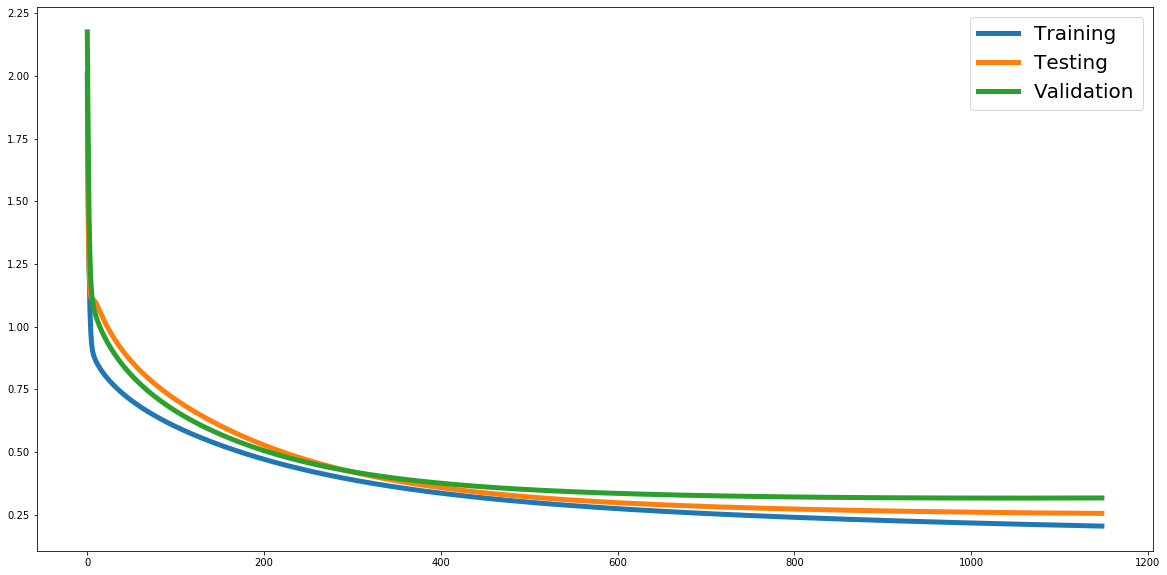

In [87]:
  
f, ax = plt.subplots(1, 1, figsize=(20, 10))
N = len(train_xe)
ax.plot(np.arange(N), train_xe, label='Training', linewidth=5)
ax.plot(np.arange(N), test_xe, label='Testing', linewidth=5)
ax.plot(np.arange(N), valid_xe, label='Validation', linewidth=5)
ax.legend(fontsize=20)


## Cross-Validation

* Relying on one training / testing split to gauge model generalization performance might be misleading because a particular split might have pathological cases

* A better approach is to use cross validation:

![alt text](figures/cv.png)

* Here, the dataset is split into $N$ folds and training / testing is run $N$ times. In the $k$th run, the $k$th fold is used for testing while the remaining folds are used for training.

* Model performance is then just the average of performances on all runs

* Here we are using cross-validation for model selection
 

In [101]:
# run this multiple times
from sklearn.model_selection import KFold

# an example array
X = np.array(["a", "b", "c", "d"])

# class to do splitting
kf = KFold(n_splits=2, shuffle=True)

# this loop iterates over folds
# train_ix and test_ix are the INDECIES into X (not the actual elements)
for train_ix, test_ix in kf.split(X):
    print(X[train_ix])
    print(X[test_ix])
    print()

['b' 'd']
['a' 'c']

['a' 'c']
['b' 'd']

